In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

In [75]:
# load the data
train_data = pd.read_csv("dataset/train.csv", sep="\t", encoding='UTF-8')
test_data = pd.read_csv("dataset/test.csv", sep="\t", encoding='UTF-8')

#view the data
train_data.head()

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0


In [76]:
test_data.head()

,id,text
0,2,The 2017 Teen Choice Awards ceremony was held ...
1,3,"The concert, part of “The Joshua Tree Tour,” w..."
2,4,Selena Gomez refuses to talk to her mother abo...
3,5,This is worse than a lump of coal in your stoc...
4,6,Luann De Lesseps is going to rehab after her a...


### Bag of Words Pipeline

In [77]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [78]:
train_data["text"].loc[0]

'Get the latest from TODAY Sign up for our newsletter  No one ever truly gets over losing a loved one, and Blake Shelton is no exception. He was just 14 when his older brother Richie died on Nov. 13, 1990. And, as Shelton noted in a tweet Monday, "It changed my life forever."  Richie was 24 when he died in a car accident in the Sheltons\' home state of Oklahoma. Two years ago, Shelton sent out a message for the 25th anniversary of his loss:  Richie, who was Blake\'s half-brother (they shared a mother), was a passenger in a car that collided with a school bus in Ada, south of Oklahoma City.  Richie, driver Redena McManus and a 3-year-old boy, Christopher McManus, all died during or shortly after the collision, while the bus driver and passengers were uninjured, according to police reports.  The accident has clearly remained with Blake, who told 60 Minutes in 2014, "I remember picking up the phone to call him a week after he was dead, to tell him something. I was picking up the phone to 

In [79]:
train_data["text"].loc[: 5].values.tolist()[0]

'Get the latest from TODAY Sign up for our newsletter  No one ever truly gets over losing a loved one, and Blake Shelton is no exception. He was just 14 when his older brother Richie died on Nov. 13, 1990. And, as Shelton noted in a tweet Monday, "It changed my life forever."  Richie was 24 when he died in a car accident in the Sheltons\' home state of Oklahoma. Two years ago, Shelton sent out a message for the 25th anniversary of his loss:  Richie, who was Blake\'s half-brother (they shared a mother), was a passenger in a car that collided with a school bus in Ada, south of Oklahoma City.  Richie, driver Redena McManus and a 3-year-old boy, Christopher McManus, all died during or shortly after the collision, while the bus driver and passengers were uninjured, according to police reports.  The accident has clearly remained with Blake, who told 60 Minutes in 2014, "I remember picking up the phone to call him a week after he was dead, to tell him something. I was picking up the phone to 

In [81]:
train_df = train_data.copy()
test_df = test_data.copy()

In [82]:
import sklearn

In [83]:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
def preprocess_data(data):
    tk = RegexpTokenizer('\s+', gaps=True)
    text_data = []
    for values in data.text:
        tokenized_data = tk.tokenize(values) #Tokenize the news
        text_data.append(tokenized_data)
        
    #stopword removal
    sw = stopwords.words('english')
    clean_data = [] # list for storing clean text
    for data in text_data:
        clean_text = [words.lower() for words in data if words.lower() not in sw]
        clean_data.append(clean_text) #append the clean text in the clean_data list
        
    #stemming
    ps = PorterStemmer() #create a stem object
    stemmed_data = []
    for data in clean_data:
        stemmed_text = [ps.stem(words) for words in data] #stem the words
        stemmed_data.append(stemmed_text) #append the stemmed text
        
    # flattend the stem
    updated_data = []
    for data in stemmed_data:
        updated_data.append(" ".join(data))
        
    #TFID vector object
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(updated_data)
    
    return tfidf_matrix
    

In [85]:
#call the function on the merged train and test data
train_data_len = train_data.shape[0]
merged_data = pd.concat((train_data.drop('label', axis=1), test_data.drop('id', axis=1)), axis=0).reset_index().drop('index', axis=1)

In [86]:
#view the merged data
merged_data.head()

,text
0,Get the latest from TODAY Sign up for our news...
1,2d Conan On The Funeral Trump Will Be Invited...
2,It’s safe to say that Instagram Stories has fa...
3,Much like a certain Amazon goddess with a lass...
4,At a time when the perfect outfit is just one ...


In [87]:
#preprocess the merged data
preprocess_data = preprocess_data(merged_data)
preprocess_data

<6234x67538 sparse matrix of type '<class 'numpy.float64'>'
	with 1395819 stored elements in Compressed Sparse Row format>

In [88]:
train_data = preprocess_data[: train_data_len]
test_data = preprocess_data[train_data_len :]

In [89]:
#view the train data
train_data

<4987x67538 sparse matrix of type '<class 'numpy.float64'>'
	with 1121447 stored elements in Compressed Sparse Row format>

In [90]:
#view the test data
test_data

<1247x67538 sparse matrix of type '<class 'numpy.float64'>'
	with 274372 stored elements in Compressed Sparse Row format>

### Developing the model

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, train_df.label, test_size=0.2, random_state=42)

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [93]:
#lets create a python dictionary and a function to evaluate each models accuracy score and predict on the model with the highest accuracy score
models = {"Random Forest Classifier": RandomForestClassifier(),
         "Logistic Regression CV" : LogisticRegressionCV(),
         "ExtraTrees Classifier": ExtraTreesClassifier(),
         "MultinomialNB" : MultinomialNB(),
         "XGB Classifier": XGBClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    This function will fit and score the model on the training and test data respectively.
    
    """
    model_scores = {}
    np.random.seed(42)
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

In [94]:
#function call
model_score = fit_and_score(models, X_train, X_test, y_train, y_test)

[16:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [95]:
model_score

{'Random Forest Classifier': 0.7545090180360722,
 'Logistic Regression CV': 0.7715430861723447,
 'ExtraTrees Classifier': 0.749498997995992,
 'MultinomialNB': 0.6633266533066132,
 'XGB Classifier': 0.7705410821643287}

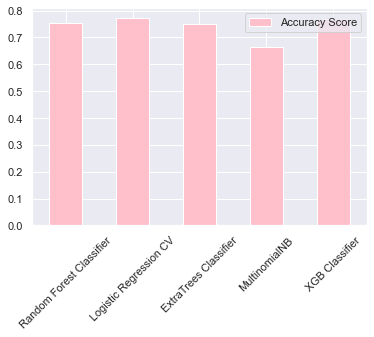

In [96]:
model_viz = pd.DataFrame(model_score,
                        index=["Accuracy Score"])
model_viz.T.plot(kind="bar", color=["pink"])
plt.xticks(rotation=45)
plt.show()

In [97]:
log_reg = LogisticRegressionCV(Cs=20, cv=3, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, cv=3, random_state=42)

In [98]:
np.random.seed(42)
log_reg.score(X_test,y_test)

0.7785571142284569

In [100]:
#Make predictions
preds = log_reg.predict(test_data)
#submission
test_ID= test_df.id
submission = pd.DataFrame({'id' : test_ID, "label": preds})
submission.to_csv("submission.csv", index=False)

In [101]:
sub_df = pd.read_csv("submission.csv")
sub_df.head()

,id,label
0,2,0
1,3,0
2,4,1
3,5,1
4,6,0


In [102]:
test_df.head()

,id,text
0,2,The 2017 Teen Choice Awards ceremony was held ...
1,3,"The concert, part of “The Joshua Tree Tour,” w..."
2,4,Selena Gomez refuses to talk to her mother abo...
3,5,This is worse than a lump of coal in your stoc...
4,6,Luann De Lesseps is going to rehab after her a...
